In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, chi2_contingency, f_oneway, zscore
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# **Introduction**

Cars are everywhere and there are a lot of them. In the United States, there are 0.85 cars per person and the average car on the road has 1.5 people in it. Cars are advertized to us all the time, promoting different features and attributes to make them desirable. Some people are on the road a lot, and they want a car with the great miles per gallon to make their trips cost less. Some people need vehicles of a specific size, so they may prioritize cylinders and engine size. Others may be environmentally contientius, and they prioritize CO₂ emissions and smog rating. The latter is important; how different types of cars polute the environment. Our goal is to investigate the attributes of modern cars to draw conslusions about most common features and find relationships between physical attributes and environmental-related attributes. What's the distribution of Miles per Gallon? What attributes are correlated with CO₂ emmissions? (Engine Size? Fuel Type?) How does the fuel type affect air pollution from the til pipe (smog rating)? Knowing the physical attributes of a car, can we accurately and consistently predict it's CO₂ emmissions? Knowing what kinds of cars are out there and how attributes of cars impact its polution, we can get a better understanding as to how much of an impact we can make as a society by choosing environmentally-friendly cars.

**Dataset:**
https://www.kaggle.com/datasets/sajivankunarethinam/co2-emission-by-vehicle-dataset/data

In [2]:
# loading in the dataset
df = pd.read_csv("cars.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13058 entries, 0 to 13057
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            12758 non-null  float64
 1   Make                  12758 non-null  object 
 2   Model                 12758 non-null  object 
 3   Vehicle class         12758 non-null  object 
 4   Engine size (L)       12758 non-null  float64
 5   Cylinders             12758 non-null  float64
 6   Transmission          12758 non-null  object 
 7   Fuel type             12758 non-null  object 
 8   City (L/100 km)       12758 non-null  float64
 9   Highway (L/100 km)    12758 non-null  float64
 10  Combined (L/100 km)   12758 non-null  float64
 11  Combined (mpg)        12758 non-null  float64
 12  CO2 emissions (g/km)  12758 non-null  float64
 13  CO2 rating            11313 non-null  float64
 14  Smog rating           9925 non-null   float64
dtypes: float64(10), obj

Dataset Information

Number of Entries: 13085
Number of Features: 15

# **Data Preprocessing**

In [4]:
df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,2015.0,Acura,ILX,Compact,2.0,4.0,AS5,Z,9.7,6.7,8.3,34.0,191.0,NaN,NaN
1,2015.0,Acura,ILX,Compact,2.4,4.0,M6,Z,10.8,7.4,9.3,30.0,214.0,NaN,NaN
2,2015.0,Acura,ILX Hybrid,Compact,1.5,4.0,AV7,Z,6.0,6.1,6.1,46.0,140.0,NaN,NaN
3,2015.0,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.7,9.1,11.1,25.0,255.0,NaN,NaN
4,2015.0,Acura,RDX AWD,Sport utility vehicle: Small,3.5,6.0,AS6,Z,12.1,8.7,10.6,27.0,244.0,NaN,NaN


In [5]:
# filtering out cars with any missing values (b/c all fields are necessary for our analysis)
df.dropna(inplace=True)
print("Number of Entries after dropping rows w/ nulls:", len(df))

Number of Entries after dropping rows w/ nulls: 9925


Smog rating is essential for our analysis. We can see from the info() cell above that smog rating was our lowest non-null category with 9925 non-nulls. After dropping any rows with null values in any category, we get 9925 entries. That means that all cars with a smog rating also had a non-null value for every single other category. This means no valuable data entries were lost.

Here we're transforming the Data so each attribute is appropriately represented internally in the dataframe

In [6]:
# converting appropriate fields to integer fields
integer_fields = ["Model year", "Cylinders", "CO2 emissions (g/km)", "Smog rating"]
for field in integer_fields:
    df[field] = df[field].astype(int)

Here a personal choice was made for clarity of data. The fuel type labels in the original dataset are not commonly-known (especially for people whp don't visit gas stations often). The labels are mapped to their full brand names.

In [7]:
# converting the oddly-labeled fuel type abbreviations to their brand name for clarity
fuel_type_mapping = {
    "D": "Diesel",
    "Z": "Premium",
    "E": "Flex-Fuel",
    "X": "Regular"
}

df["Fuel type"] = df["Fuel type"].map(fuel_type_mapping)

Each datapoint should be unique since this is a dataset of different cars.
So duplicate entries must be removed so our aggregate and distribution analysis isn't distorted

In [8]:
# Number of Duplicated Rows
print("Number of Duplicated Rows: ", df.duplicated().sum())
df = df.drop_duplicates()

Number of Duplicated Rows:  1317


We also don't want cars entries with data that's verifiably inaccurate data.
Here we're removing entries with nonsensical attributes

In [9]:
# max model year cant be more than 2025 (current year)
df = df[df["Model year"] <= 2025]

# max engine size can't be more than 28.4L
df = df[df["Engine size (L)"] <= 28.4]

# max cylinders can't be more than 16
df = df[df["Cylinders"] <= 16]

# the best performing car is only getting 57mpg right now
df = df[df["Combined (mpg)"] <= 57]

print("Number of Entries after dropping duplicates and nonsensical data:", len(df))

Number of Entries after dropping duplicates and nonsensical data: 7761


We ended up losing 5324 entries to get down to 7761. That's definetly a lot. However, we saw that each one of those entries was either not usable due to having a missing smog rating or has verifiably data somewhere in the record. We still have an appropriate amount of data entries to perform a meaningful statistical analysis.

# **Data Exploration**

In [10]:
df.describe()

,Model year,Engine size (L),Cylinders,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
count,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000,7761.000000
mean,2020.308079,3.155676,5.645535,12.529803,9.249968,11.053344,27.114805,256.654039,4.495039,4.798093
std,2.259698,1.339913,1.901433,3.327348,2.147856,2.749851,6.758468,59.991636,1.506432,1.779342
min,2017.000000,0.900000,3.000000,4.800000,4.500000,5.000000,11.000000,114.000000,1.000000,1.000000
25%,2018.000000,2.000000,4.000000,10.200000,7.700000,9.100000,22.000000,213.000000,3.000000,3.000000
50%,2020.000000,3.000000,6.000000,12.200000,9.000000,10.700000,26.000000,253.000000,4.000000,5.000000
75%,2022.000000,3.700000,6.000000,14.500000,10.500000,12.700000,31.000000,295.000000,5.000000,6.000000
max,2024.000000,8.400000,16.000000,30.700000,20.900000,26.100000,56.000000,608.000000,10.000000,8.000000


In [11]:
# Number of Rows and Columns after cleaning
row, col = df.shape
print("Number of Entries:", row)
print("Number of Features:", col)

Number of Entries: 7761
Number of Features: 15


Exploring the distribution of our numerical attributes:

In [12]:
# NUMBER OF UNIQUE VALUES PER COLUMN
print("NUMBER OF UNIQUE VALUES PER COLUMN")
print(df.nunique())

NUMBER OF UNIQUE VALUES PER COLUMN
Model year                 8
Make                      41
Model                   1745
Vehicle class             15
Engine size (L)           47
Cylinders                  8
Transmission              26
Fuel type                  4
City (L/100 km)          197
Highway (L/100 km)       129
Combined (L/100 km)      163
Combined (mpg)            45
CO2 emissions (g/km)     311
CO2 rating                10
Smog rating                7
dtype: int64


In [13]:
# Proportion of values in Vehicle Class
df['Vehicle class'].value_counts(normalize=True) * 100

Vehicle class
Sport utility vehicle: Small       19.417601
Sport utility vehicle: Standard    13.232831
Mid-size                           12.859168
Pickup truck: Standard              9.895632
Compact                             9.792553
Subcompact                          8.787527
Full-size                           7.524804
Two-seater                          6.274965
Minicompact                         4.496843
Station wagon: Small                2.525448
Pickup truck: Small                 2.216209
Special purpose vehicle             0.992140
Minivan                             0.876176
Station wagon: Mid-size             0.863291
Van: Passenger                      0.244814
Name: proportion, dtype: float64

array([[<Axes: title={'center': 'Model year'}>,
        <Axes: title={'center': 'Engine size (L)'}>,
        <Axes: title={'center': 'Cylinders'}>],
       [<Axes: title={'center': 'City (L/100 km)'}>,
        <Axes: title={'center': 'Highway (L/100 km)'}>,
        <Axes: title={'center': 'Combined (L/100 km)'}>],
       [<Axes: title={'center': 'Combined (mpg)'}>,
        <Axes: title={'center': 'CO2 emissions (g/km)'}>,
        <Axes: title={'center': 'CO2 rating'}>],
       [<Axes: title={'center': 'Smog rating'}>, <Axes: >, <Axes: >]],
      dtype=object)

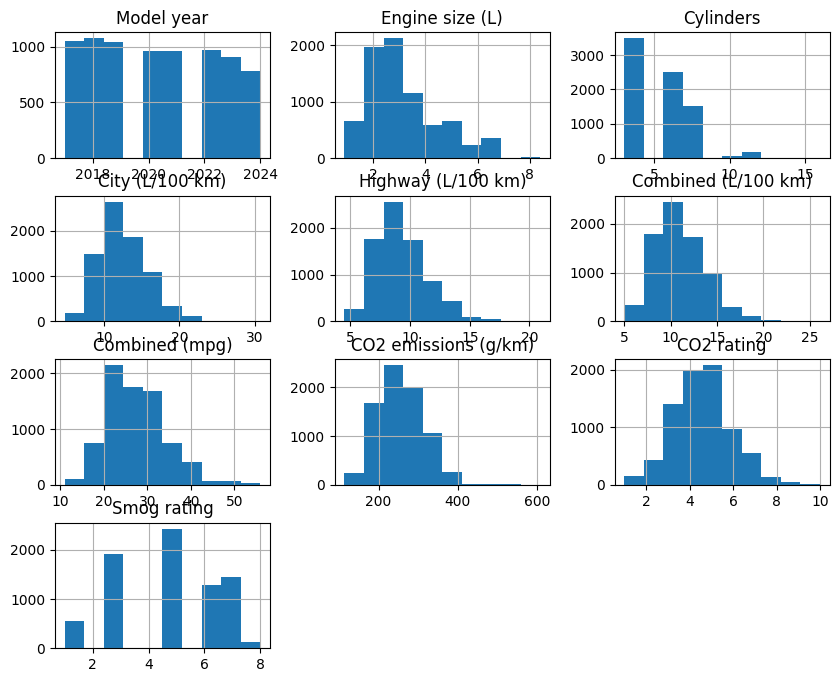

In [14]:
# Histogram for all numeric columns
df.hist(figsize=(10,8))

These histograms visually reveal that CO2 emissions (g/km), CO2 rating, and miles per gallon (combined) have a seemingly normal distribution.

In [15]:
print("Miles Per Gallon:")
print("   Mean ==>", df["Combined (mpg)"].mean())
print("   STD ==>", df["Combined (mpg)"].std())
# -------------------------------------------- #
print("CO2 Emissions:")
print("   Mean ==>", df["CO2 emissions (g/km)"].mean())
print("   STD ==>", df["CO2 emissions (g/km)"].std())
# -------------------------------------------- #
print("CO2 Rating:")
print("   Mean ==>", df["CO2 rating"].mean())
print("   STD ==>", df["CO2 rating"].std())

Miles Per Gallon:
   Mean ==> 27.114804793196754
   STD ==> 6.75846842713458
CO2 Emissions:
   Mean ==> 256.6540394279088
   STD ==> 59.991636117930454
CO2 Rating:
   Mean ==> 4.4950392990594
   STD ==> 1.5064320434978256


An average of 27mpg with a standard deviation of 6.75mpg reveals our miles per gallon datapoints are spread out. 27 is a reasonable average and the large standard deviation reflects the wide range of vehicle types in our dataset (seen a couple cells above). We have many sport utility vehicles which are known for being fuel efficient and many heavy vehicles which are fuel inefficient.

The standard deviation for CO2 emissions rating is high as well, reinforcing our variance in vehicle classes. The CO2 rating is a score given by the EPA, and we don't have their score formula. But for a 1-10 scale, a mean of 4.49 indicates the center of our data is scoring subpar for C02 emissions.

In [16]:
# finding number of outliers for miles per gallon (combined)
mpg_zscore_df = df.copy()
mpg_zscore_df["mpg_zscore"] = zscore(mpg_zscore_df["Combined (mpg)"])
mpg_zscore_df = mpg_zscore_df[abs(mpg_zscore_df["mpg_zscore"]) >= 3]
print("Number of MPG outliers:", len(mpg_zscore_df))

Number of MPG outliers: 80


In [17]:
# Count of values in Model
df['Model'].value_counts().head(25)

Model
Sierra 4WD             38
Silverado 4WD          38
Mustang                36
Silverado              30
Sierra                 30
Camaro                 30
F-150 FFV              28
Civic Sedan            26
Civic Hatchback        26
Mustang Convertible    25
Elantra                24
F-150 4X4              23
Edge AWD               23
Canyon                 23
Colorado               23
F-150                  22
Corolla                21
Challenger             21
Tacoma 4WD             20
Canyon 4WD             20
Sierra FFV             20
Silverado FFV          20
Sierra 4WD FFV         20
Explorer AWD           20
Colorado 4WD           20
Name: count, dtype: int64

In [18]:
# Proportion of values in Fuel Type
df['Fuel type'].value_counts(normalize=True) * 100

Fuel type
Premium      48.666409
Regular      46.282696
Flex-Fuel     2.667182
Diesel        2.383713
Name: proportion, dtype: float64

In [19]:
# Proportion of values in Smog Category
df['Smog rating'].value_counts(normalize=True) * 100

Smog rating
5    31.297513
3    24.674655
7    18.670274
6    16.466950
1     7.254220
8     1.546193
2     0.090195
Name: proportion, dtype: float64

In [20]:
# Average Smog rating per Fuel Type
df.groupby('Fuel type')['Smog rating'].mean()

Fuel type
Diesel       2.681081
Flex-Fuel    4.183575
Premium      4.339158
Regular      5.425111
Name: Smog rating, dtype: float64

# **Hypothesis Testing**

**Engine Size related to CO₂ Emissions?**

Largers engines generally burn more fuel than smaller engines. However, vehicles using larger engines are on the highway more often than not so their fuel efficiency might be better (relative to the engine size) than smaller engine vehicles that spend a lot of time starting and stopping in local streets. It makes sense to test this relationship.

**Regression**<br>
H0: Engine Size and CO₂ Emissions are not related<br>
HA: Engine Size and CO₂ Emissions are related

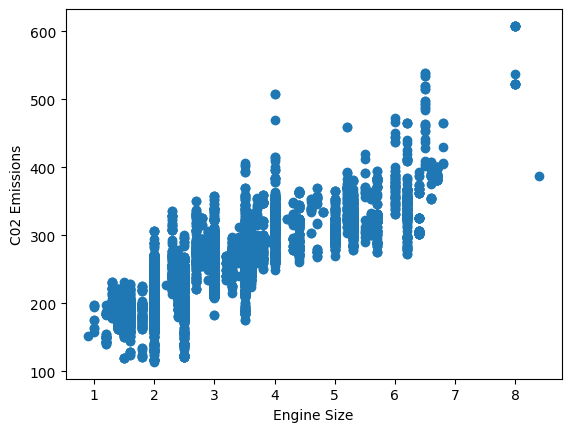

In [21]:
# visualizing hypothesis
plt.scatter(df["Engine size (L)"], df["CO2 emissions (g/km)"])
plt.xlabel("Engine Size")
plt.ylabel("C02 Emissions")
plt.show()

In [22]:
# computing p-value from regression analysis
result = linregress(df["Engine size (L)"], df["CO2 emissions (g/km)"])
print("p-value:", result.pvalue)

p-value: 0.0


There is a statistically significant association between **Engine Size** and **CO₂ emissions**

Engine Size & CO₂

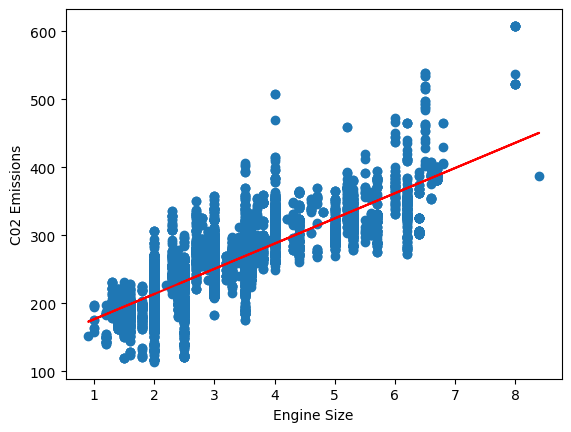

In [23]:
plt.scatter(df["Engine size (L)"], df["CO2 emissions (g/km)"])
plt.xlabel("Engine Size")
plt.ylabel("C02 Emissions")
plt.plot(df["Engine size (L)"], result.intercept + result.slope*df["Engine size (L)"], 'r', label='fitted line')
plt.show()

**Fuel Type related to CO₂ Emissions?**

Different fuel types generally produce varying levels of CO₂ when burned or used to power vehicles. Gasoline engines typically emit more CO₂ than diesel per unit of fuel, while electric vehicles may produce little to none. Since fuel composition and combustion efficiency differ across types, it makes sense to test whether fuel type significantly affects CO₂ emissions.

**One-Way ANOVA**<br>
H0: Fuel type does not affect CO2 emissions<br>
HA: Fuel type significantly affects CO2 emissions

In [24]:
# Get the list of fuel types and corresponding emissions
fuel_groups = [group['CO2 emissions (g/km)'].values
               for name, group in df.groupby('Fuel type')]

# Run ANOVA
f_stat, p_value = f_oneway(*fuel_groups)
print("ANOVA Test Results:")
print(f"F-statistic = {f_stat:.3f}")
print(f"P-value = {p_value:.5f}")

ANOVA Test Results:
F-statistic = 230.819
P-value = 0.00000


There is a statistically significant association between **Fuel Type** and **CO₂ emissions**

Fuel Type and CO₂

/var/folders/4j/bzjzr7sx5cv9skphgq447myw0000gn/T/ipykernel_13544/2492406405.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Fuel type', y='CO2 emissions (g/km)', palette='Set3')


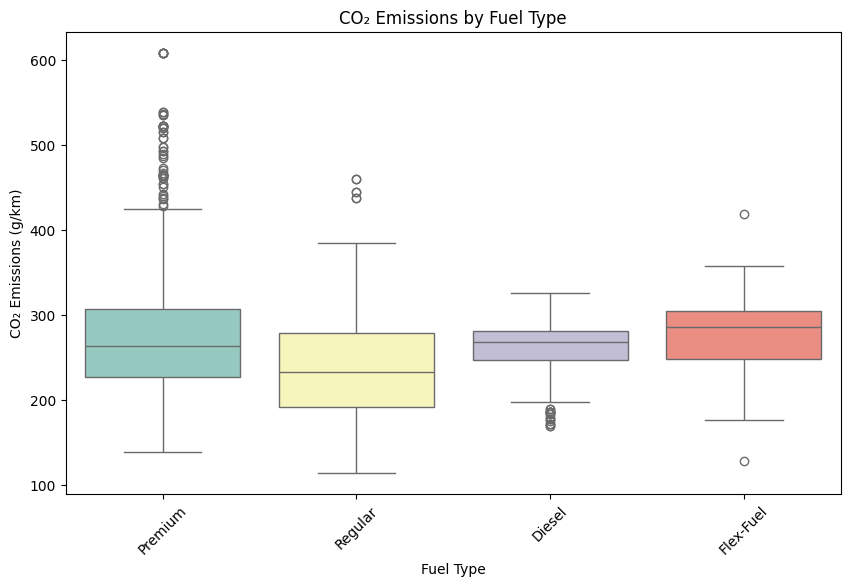

In [25]:
# Visualization
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Fuel type', y='CO2 emissions (g/km)', palette='Set3')
plt.title('CO₂ Emissions by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('CO₂ Emissions (g/km)')
plt.xticks(rotation=45)
plt.show()

**Follow-Up Tukey Test**

In [26]:
anova_df = df[["Fuel type", "CO2 emissions (g/km)"]]

tukey = pairwise_tukeyhsd(
    endog=anova_df["CO2 emissions (g/km)"],   # Dependent variable
    groups=anova_df["Fuel type"],             # Categorical variable
    alpha=0.05                                # Significance level
)

print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1    group2  meandiff p-adj   lower    upper   reject
------------------------------------------------------------
   Diesel Flex-Fuel   20.979 0.0018   6.0324  35.9256   True
   Diesel   Premium  14.2602 0.0055    3.136  25.3844   True
   Diesel   Regular -20.1278    0.0 -31.2654  -8.9903   True
Flex-Fuel   Premium  -6.7188 0.3577 -17.2644   3.8268  False
Flex-Fuel   Regular -41.1068    0.0 -51.6666 -30.5471   True
  Premium   Regular  -34.388    0.0  -37.831 -30.9451   True
------------------------------------------------------------


There are significant differences in mean CO₂ emissions between most fuel types (p < 0.05). In particular, Regular-fuel vehicles consistently produced **higher** CO₂ emissions compared to Diesel, Flex-Fuel, and Premium vehicles. Flex-Fuel and Premium vehicles had lower emissions on average, while Diesel vehicles emitted moderately higher levels compared to those but still significantly less than Regular-fuel vehicles.

The only comparison that **didn't** yield significant results was Flex-Fuel vs. Premium

**Fuel Type related to Smog Rating Category?**

Smog ratings indicate how much a vehicle contributes to air pollution based on emissions of harmful gases. Different fuel types produce varying levels of pollutants, which can influence these ratings. Because fuel combustion and emission control technologies differ by fuel type, it makes sense to test whether there is an association between fuel type and smog rating category.

**Chi-Square Test of Independence**<br>
H0: There is no association between fuel type and smog rating category.<br>
HA: There is an association between fuel type and smog rating category.<br><br>

*Note -> Regarding smog ratings, vehicles that score a 10 are the **cleanest**. The categories are defined as such:<br>

*   Low: 1–3
*   Medium: 4–7
*   High: 8–10





In [27]:
# Creating smog rating categories
def categorize_smog(rating):
    if rating <= 3:
        return "Low"
    elif rating <= 7:
        return "Medium"
    else:
        return "High"

df["Smog Category"] = df["Smog rating"].apply(categorize_smog)

# Build the contingency table
contingency = pd.crosstab(df["Fuel type"], df["Smog Category"])

# Run the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency)
print("\nChi-square test results:")
print(f"Chi2 Statistic: {chi2:.3f}")
print(f"P-value: {p:.4f}")


Chi-square test results:
Chi2 Statistic: 809.302
P-value: 0.0000


There is a statistically significant association between **Fuel Type** and **Smog Rating Category**

Fuel Type and Smog Rating Category

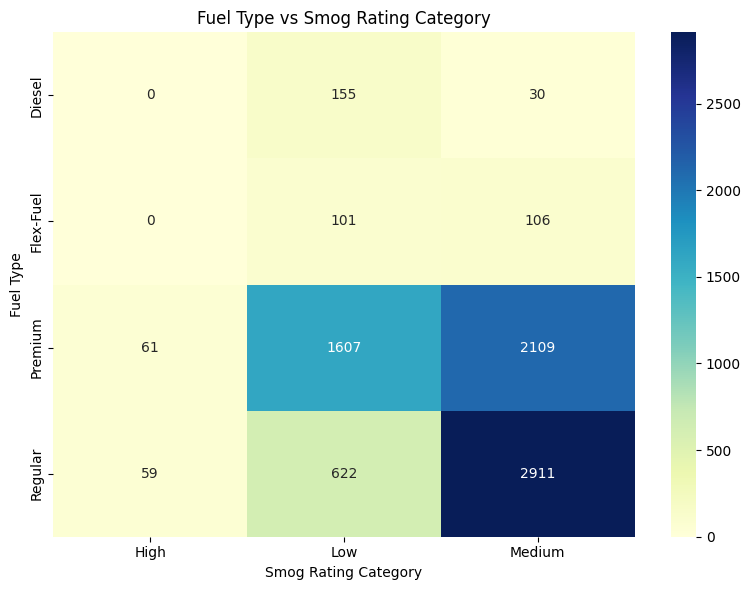

In [28]:
# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(contingency, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Fuel Type vs Smog Rating Category")
plt.xlabel("Smog Rating Category")
plt.ylabel("Fuel Type")
plt.tight_layout()
plt.show()

In [29]:
# dont need the smog category anymore
df.drop(columns=["Smog Category"], inplace=True)

# **Machine Learning Analysis**

In [30]:
# Dropping unneeded categories
machine_learning_df = df.copy()

**Feature Engineering**

First we're converting the fuel type (nominal attribute) to a binary representation of the fuel type using one-hot encoding so our machine learning model can handle the fuel type feature. There's 4 fuel types, so we only expand our dataset by 3 columns since we'll end up dropping the original fuel type column.

In [31]:
fuel_encoded = pd.get_dummies(machine_learning_df["Fuel type"])
machine_learning_df = pd.concat([machine_learning_df, fuel_encoded], axis=1)
machine_learning_df.drop(columns=["Fuel type"], inplace=True)
machine_learning_df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating,Diesel,Flex-Fuel,Premium,Regular
2234,2017,Acura,ILX,Compact,2.4,4,AM8,9.4,6.8,8.2,34.0,192,7.0,6,False,False,True,False
2235,2017,Acura,MDX Hybrid AWD,Sport utility vehicle: Small,3.0,6,AM7,9.1,9.0,9.0,31.0,210,6.0,6,False,False,True,False
2236,2017,Acura,MDX SH-AWD,Sport utility vehicle: Small,3.5,6,AS9,12.6,9.0,11.0,26.0,259,4.0,6,False,False,True,False
2237,2017,Acura,MDX SH-AWD Elite,Sport utility vehicle: Small,3.5,6,AS9,12.2,9.0,10.7,26.0,251,5.0,6,False,False,True,False
2238,2017,Acura,NSX,Two-seater,3.5,6,AM9,11.1,10.8,11.0,26.0,261,4.0,6,False,False,True,False


Now, as we discovered earlier, we have 15 unique classes of vehicles. We know that vehicle class heavily influences the size and weight of the vehicle which impact the number of number of cylinders and engine size. So here, we will use target (mean) encoding on the vehicle class category. Here we avoid expanding our dataset by 14 dimensions; the tradeoff being that information about the target (CO2) is now present in our dataset. But as mentioned, other attributes of the vehicles are dependent on vehicle class; so since it's arguably the most impactful feature, it's acceptable here to use target mean encoding.

In [32]:
# target mean encoding
vehicle_class_to_CO2_mean_map = {}

vehicle_classes = machine_learning_df.groupby("Vehicle class")
for vehicle_class, table in vehicle_classes:
    CO2_mean = table["CO2 emissions (g/km)"].mean()
    vehicle_class_to_CO2_mean_map[vehicle_class] = CO2_mean

machine_learning_df["Vehicle class"] = machine_learning_df["Vehicle class"].map(vehicle_class_to_CO2_mean_map)
machine_learning_df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating,Diesel,Flex-Fuel,Premium,Regular
2234,2017,Acura,ILX,216.181579,2.4,4,AM8,9.4,6.8,8.2,34.0,192,7.0,6,False,False,True,False
2235,2017,Acura,MDX Hybrid AWD,233.006636,3.0,6,AM7,9.1,9.0,9.0,31.0,210,6.0,6,False,False,True,False
2236,2017,Acura,MDX SH-AWD,233.006636,3.5,6,AS9,12.6,9.0,11.0,26.0,259,4.0,6,False,False,True,False
2237,2017,Acura,MDX SH-AWD Elite,233.006636,3.5,6,AS9,12.2,9.0,10.7,26.0,251,5.0,6,False,False,True,False
2238,2017,Acura,NSX,296.714579,3.5,6,AM9,11.1,10.8,11.0,26.0,261,4.0,6,False,False,True,False


In [33]:
print(machine_learning_df["Transmission"].unique())

['AM8' 'AM7' 'AS9' 'AM9' 'AS6' 'AM6' 'A8' 'M7' 'M6' 'AS8' 'A6' 'AS10' 'AV'
 'A9' 'M5' 'A5' 'A4' 'AV7' 'AS7' 'AV6' 'AV8' 'AS5' 'A7' 'A10' 'AV10' 'AV1']


Now we need to handle the transmission type.

For context:

*   A  ==> Automatic (car automatically shifts gears)
*   M  ==> Manual (driver shifts gears)
*   AM ==> Automated Manual (manual transmission but controlled by computer)
*   AS ==> Automatic Selectable (AM but can be overridden by driver)
*   AV ==> Continuously Variable Transmission (no gears - car uses pulleys to adjust to the best RPM)
*   1 - 10 ==> Number of gears (simulated gears for AV)


In reality, the transmission type is what matters here, not the gears. Gear number has minimal impact; and having a lower gear in one transmission type might be better for CO2 while having a higher gear in another might also be better for CO2. So we're gonna drop the gear number to avoid having to make the model way more complex than it needs to be.

We'll do some one hot encoding for the 5 transmission types

In [34]:
# dropping the gear number
def remove_gear_number(transmission):
    if (transmission.startswith("AM")):
        return "Automated Manual"
    elif (transmission.startswith("AS")):
        return "Automatic Selectable"
    elif (transmission.startswith("AV")):
        return "Continuously Variable"
    elif (transmission.startswith("A")):
        return "Automatic"
    else:
        return "Manual"

machine_learning_df["Transmission"] = machine_learning_df["Transmission"].apply(remove_gear_number)

# one hot encoding
transmission_encoded = pd.get_dummies(machine_learning_df["Transmission"])
machine_learning_df = pd.concat([machine_learning_df, transmission_encoded], axis=1)
machine_learning_df.drop(columns=["Transmission"], inplace=True)
machine_learning_df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),...,Smog rating,Diesel,Flex-Fuel,Premium,Regular,Automated Manual,Automatic,Automatic Selectable,Continuously Variable,Manual
2234,2017,Acura,ILX,216.181579,2.4,4,9.4,6.8,8.2,34.0,...,6,False,False,True,False,True,False,False,False,False
2235,2017,Acura,MDX Hybrid AWD,233.006636,3.0,6,9.1,9.0,9.0,31.0,...,6,False,False,True,False,True,False,False,False,False
2236,2017,Acura,MDX SH-AWD,233.006636,3.5,6,12.6,9.0,11.0,26.0,...,6,False,False,True,False,False,False,True,False,False
2237,2017,Acura,MDX SH-AWD Elite,233.006636,3.5,6,12.2,9.0,10.7,26.0,...,6,False,False,True,False,False,False,True,False,False
2238,2017,Acura,NSX,296.714579,3.5,6,11.1,10.8,11.0,26.0,...,6,False,False,True,False,True,False,False,False,False


The last major feature transformation we want to do here is encoding the make of the vehicle. If you take two cars, 1 from one manufacturer and one from another, and they both have the same specs (like transmission type). We saw earlier, theres 41 different makes, so one hot encoding would expand out dataset too much. It's not ideal, but we're going to use label encoding here.

In [35]:
label_encoder = LabelEncoder()
make_column = list(machine_learning_df["Make"].values)
machine_learning_df["Make"] = label_encoder.fit_transform(make_column)
machine_learning_df.head()

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),...,Smog rating,Diesel,Flex-Fuel,Premium,Regular,Automated Manual,Automatic,Automatic Selectable,Continuously Variable,Manual
2234,2017,0,ILX,216.181579,2.4,4,9.4,6.8,8.2,34.0,...,6,False,False,True,False,True,False,False,False,False
2235,2017,0,MDX Hybrid AWD,233.006636,3.0,6,9.1,9.0,9.0,31.0,...,6,False,False,True,False,True,False,False,False,False
2236,2017,0,MDX SH-AWD,233.006636,3.5,6,12.6,9.0,11.0,26.0,...,6,False,False,True,False,False,False,True,False,False
2237,2017,0,MDX SH-AWD Elite,233.006636,3.5,6,12.2,9.0,10.7,26.0,...,6,False,False,True,False,False,False,True,False,False
2238,2017,0,NSX,296.714579,3.5,6,11.1,10.8,11.0,26.0,...,6,False,False,True,False,True,False,False,False,False


Now its time for the Machine Learning to begin

Note before starting machine learning (to be rewritten later)

We're trying to figure out how the physical attributes of a car impacts its CO2 emissions. Miles per gallon and all 3 of those liters per 100 kilometers columns tell you how efficient the fuel system is which determines the CO2 emissions. So the car's features, as they relate to CO2 emissions, are already calculated in to those categories. So we're going to ignore those.

Justification for dropping categories:

*   Model year ==> not a physical attribute (impact embedded in physical attributes of car)
*   Model ==> not a physical attribute (impact embedded in physical attributes of car)
*   CO2 rating ==> classification of the output - not appropriate for input

In [36]:
# getting inputs (X) and labels (Y)
X = machine_learning_df[["Make", "Vehicle class", "Engine size (L)", "Cylinders", "Smog rating", "Diesel", "Flex-Fuel", "Premium", "Regular", "Automated Manual", "Automatic", "Automatic Selectable", "Continuously Variable", "Manual"]]
y = machine_learning_df["CO2 emissions (g/km)"]

In [37]:
# splitting training set: 80% train and 20% test
random_state = 42
np.random.seed(random_state)
test_size = 0.2

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state)

In [38]:
# Normalize the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled)
Y_train_tensor = torch.from_numpy(np.asarray(Y_train).reshape(-1, 1))
X_test_tensor = torch.tensor(X_test_scaled)
Y_test_tensor = torch.from_numpy(np.asarray(Y_test).reshape(-1, 1))

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_size = train_loader.batch_size
num_train_data = len(train_loader) * batch_size
num_test_data = len(test_loader) * batch_size
feat_dim = train_loader.dataset[0][0].shape[0]

In [39]:
class MLPModel(nn.Module):
    def __init__(self, feat_dim):
        super(MLPModel, self).__init__()
        self.layer1 = nn.Linear(feat_dim, feat_dim * 5, dtype=float)
        self.layer2 = nn.Linear(feat_dim * 5, feat_dim * 2, dtype=float)
        self.layer3 = nn.Linear(feat_dim * 2, 1, dtype=float)

    def forward(self, x):
        return self.layer3(F.relu(self.layer2(F.relu(self.layer1(x)))))

# Instantiate the model
model = MLPModel(feat_dim=X_train.shape[1])

In [40]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 250
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Forward pass
        output = model.forward(data)
        # Backward pass
        targets = targets.double()
        loss = criterion(output, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

print('Finished Training')

Epoch 1/250, Loss: 419.62513413650186
Epoch 2/250, Loss: 725.1696307923402
Epoch 3/250, Loss: 531.7826622358505
Epoch 4/250, Loss: 583.9391472370866
Epoch 5/250, Loss: 784.4094904703442
Epoch 6/250, Loss: 312.59336074900733
Epoch 7/250, Loss: 626.5319432965647
Epoch 8/250, Loss: 685.8906457399216
Epoch 9/250, Loss: 826.8577317946488
Epoch 10/250, Loss: 643.0288184567299
Epoch 11/250, Loss: 772.000548976276
Epoch 12/250, Loss: 847.8242302082759
Epoch 13/250, Loss: 985.438719544253
Epoch 14/250, Loss: 732.2741571042161
Epoch 15/250, Loss: 838.643444591612
Epoch 16/250, Loss: 559.17732319827
Epoch 17/250, Loss: 729.0794145830231
Epoch 18/250, Loss: 537.1056947980619
Epoch 19/250, Loss: 425.88694341375697
Epoch 20/250, Loss: 502.164724471245
Epoch 21/250, Loss: 1124.3012871271483
Epoch 22/250, Loss: 658.864452919396
Epoch 23/250, Loss: 463.31378657149435
Epoch 24/250, Loss: 588.1528930320308
Epoch 25/250, Loss: 348.1449032839418
Epoch 26/250, Loss: 539.2734186973903
Epoch 27/250, Loss: 566

Train Loss: 296.35804048513626
Test Loss: 357.9319278800644


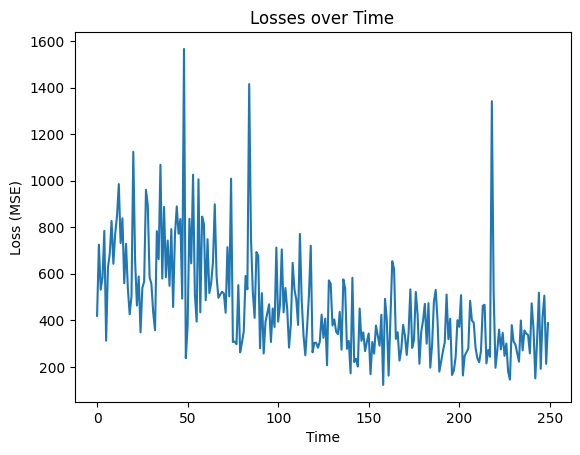

In [41]:
test_loss = 0.0
for batch_idx, (data, targets) in enumerate(test_loader):
    loss = criterion(model(data), targets)
    test_loss += loss.item()
test_loss = test_loss / len(test_loader)

train_loss = 0.0
for batch_idx, (data, targets) in enumerate(train_loader):
    loss = criterion(model(data), targets)
    train_loss += loss.item()
train_loss = train_loss / len(train_loader)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

plt.plot(losses)
plt.title("Losses over Time")
plt.xlabel("Time")
plt.ylabel("Loss (MSE)")
plt.show()

**MLP Model Evaluation**

(remove later: this is where Kaleb started working)

In [42]:
# Convert predictions
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).numpy()
    y_pred_test = model(X_test_tensor).numpy()

# Calculate metrics
train_r2 = r2_score(Y_train, y_pred_train)
test_r2 = r2_score(Y_test, y_pred_test)
train_mse = mean_squared_error(Y_train, y_pred_train)
test_mse = mean_squared_error(Y_test, y_pred_test)

print(f"Train R² Score: {train_r2:.3f}")
print(f"Test R² Score : {test_r2:.3f}")
print(f"Train MSE     : {train_mse:.2f}")
print(f"Test MSE      : {test_mse:.2f}")

Train R² Score: 0.919
Test R² Score : 0.893
Train MSE     : 296.36
Test MSE      : 359.71


**Plotting Predicted vs. Actual**

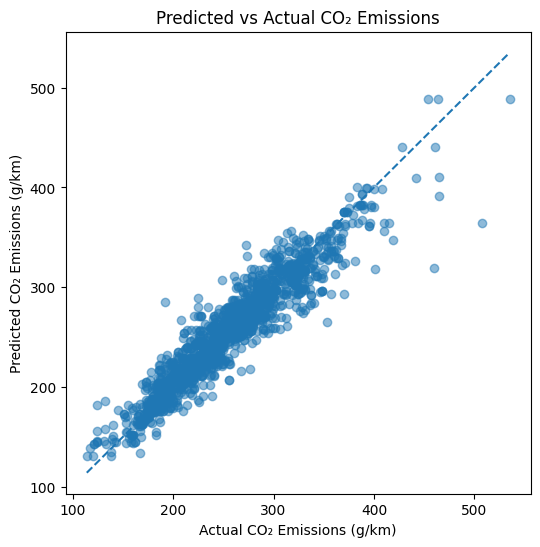

In [43]:
plt.figure(figsize=(6,6))
plt.scatter(Y_test, y_pred_test, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], linestyle='--')
plt.xlabel("Actual CO₂ Emissions (g/km)")
plt.ylabel("Predicted CO₂ Emissions (g/km)")
plt.title("Predicted vs Actual CO₂ Emissions")
plt.show()

### **5 Comparing with a Tree-Based Regression Model**

We chose a regression model rather than classification or clustering because our target, CO₂ emissions, is a continuous value we want to predict. Among regression approaches, tree-based ensemble models (especially Random Forest) are most appropriate for this dataset because they handle nonlinear relationships and mixed feature types well, often outperforming linear models for real-world emission data.

**Why regression?** CO₂ is a continuous quantity, and regression models (linear & tree-based) directly predict the numeric values.

**Why Random Forest?** Tree ensembles capture nonlinearity and interactions (e.g., engine size × vehicle weight), and often outperform linear models on tabular datasets.

**Why not Neural Networks?** Overkill for structured tabular data. Also requires tuning & more data



**Random Forest Regression Training & Evaluation**

In [44]:
rf_model = RandomForestRegressor(
    n_estimators=300,       # Number of trees (can tune later)
    max_depth=None,         # Let trees expand fully
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, Y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

# Evaluation
rf_train_mse = mean_squared_error(Y_train, rf_train_pred)
rf_test_mse = mean_squared_error(Y_test, rf_test_pred)

rf_train_r2 = r2_score(Y_train, rf_train_pred)
rf_test_r2 = r2_score(Y_test, rf_test_pred)

print(f"Train R²:  {rf_train_r2:.3f}")
print(f"Test R²:   {rf_test_r2:.3f}")
print(f"Train MSE: {rf_train_mse:.2f}")
print(f"Test MSE:  {rf_test_mse:.2f}")

Train R²:  0.961
Test R²:   0.940
Train MSE: 142.92
Test MSE:  202.79


**6 Visualizing Feature Importance**

[7.28003687e-01 6.72972610e-02 5.88320207e-02 4.09832381e-02
 3.88086796e-02 3.24501219e-02 8.98743624e-03 6.96303458e-03
 4.78680407e-03 4.40177744e-03 3.26383998e-03 3.00487605e-03
 1.87813501e-03 3.39087867e-04]


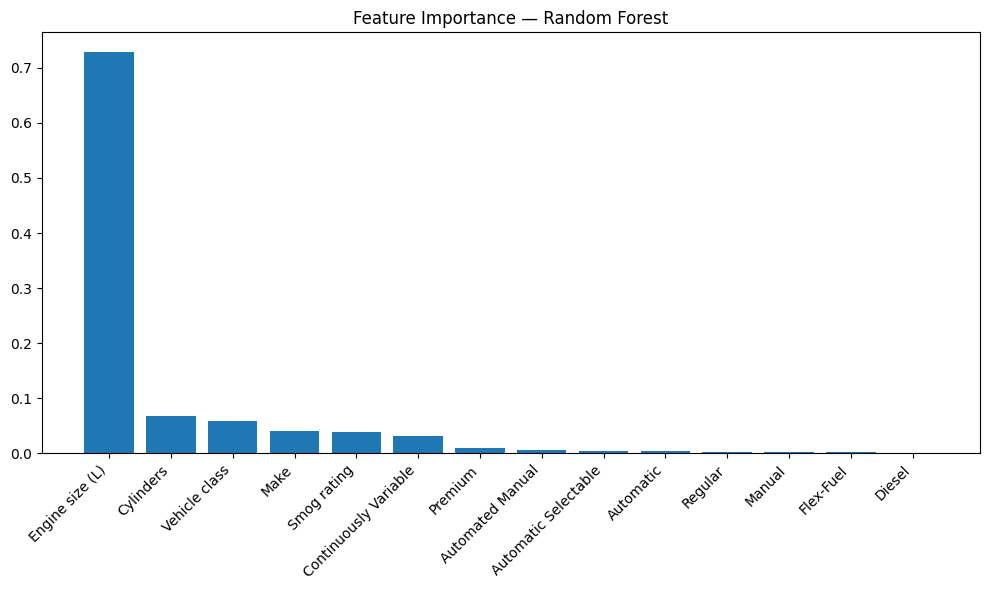

In [47]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print(importances[indices])
plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=45, ha="right")
plt.title("Feature Importance — Random Forest")
plt.tight_layout()
plt.show()

**Results**

Looking at the feature important visualization, immediately the engine size jumps out as the most obvious and impactful attribute. With a value of .728, we can say that knowing the engine size provides an information gain of .728. More abstractly stated, engine size contributes about 72% to the prediction of the CO2 emissions. Engine size is 7 times more impactful than the second closest attribute, cylinders, which contributed 6.2% to the prediction of CO2 emissions. The third most impactful attribute was vehicle class (ex: pickup truck standard, compact) contributing 5.88% to the CO2 emission prediction. Other attributes of minor contributions are make (brand of the car) contributing 4.09%, smog rating (1 - 10 rating for how well the car does at reducing tailpipe emissions) contributing 3.88% to the prediction, and finally "Continuously Variable" which (a feature engineered binary attribute for whether the vehicle had continuously variable transmission or not) contributing 3.24% to the prediction. All other attributes contributed less than 1% so they are negligable, including fuel-type (more on fuel-type is part 7).

**7. Insights and Conclusions**

The results are suprising because they counter the current narratives about fuel type and transmission effect on CO2; and instead, attribute the fuel efficiency almost exclusively to the CO2 output of a car. These narratives are:
- vehicles using diesel fuel have higher thermal efficiency which leads to lower CO2 emitted per kilometer traveled compared to gas-fueled vehicles.

Part A: size is the dominant property of a vehicle that determines how much CO2 it emits

The results indicate that engine size is the critical driving factor for determining CO2 emissions. Note that engine size is associated with the size of the vehicle. Larger vehicles require larger engine sizes because they require more power to drive. More power means more carbon burning which means more CO2 emissions.

Looking at the second and third most impactful attributes, they are also related to vehicle size: cylinders and vehicle class. The cylinders are the number of central power units in the engine. Having more cylinders means the engine is capable of generating more power. This means burning more fuel and as a result, emmitting more CO2. Cars that are heavier need more power to move than lighter cars, so heavier (bigger) cars require more cylinders. Vehicle class describes the shape and size of the car so its clearly related to vehicle size as well.

Now its probably not suprising that a vehicles's size contributes heavily towards its CO2 emissions. However, it is definitely suprising that the fuel type has a negligable impact on a vehicle's CO2 emissions.

Part B: When considering the fuel efficiency of a car in practice (how it actaully performs on the road- not just in a test environment), the fuel type is a statistically insignificant contributor.